In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

### Basic settings

In [2]:
skim_type = 'dist'
time = 'AM'
var = 'DISTDA'
geo = 'taz'
mode = 'auto'
mtc_fname = f'../data/outputs/{mode}/{geo}_{skim_type}_skim_{time}_perveh.csv'
new_fname = f'../data/new_outputs/{mode}/{geo}_{skim_type}_skim_{time}_perveh.csv'

### Helper functions

In [3]:
def compare_skim(mtc_skim, new_skim, var, geo):
    # select column to compare
    select_col = [f'{geo}_o', f'{geo}_d', var]
    mtc_skim = mtc_skim[select_col]
    new_skim = new_skim[select_col].rename(columns={var:f'{var}_new'})

    print('mtc skim shape:', mtc_skim.shape)
    print('new skim shape:', new_skim.shape)

    # table join two skims based on OD pair
    skim = pd.merge(mtc_skim, new_skim, how='inner', on=[f'{geo}_o', f'{geo}_d'])
    # print(skim.shape)
    print(skim.head())
    print('table join completed')

    # calculate differences
    skim['diff'] = round(skim[f'{var}_new'] - skim[var], 3)
    skim['pctdiff'] = round(skim['diff'] / skim[var], 3)
    skim = skim.sort_values(by=f'diff', ascending=False)
    
    return skim

def get_n_large_skim_diff(skim_diff, diff_col, n):
    skim_diff_sorted = skim_diff.sort_values(by=diff_col, ascending=False)
    pos_rows = skim_diff_sorted.head(n)
    neg_rows = skim_diff_sorted.tail(n)

    return pd.concat([pos_rows, neg_rows], ignore_index=True)

def skim_diff_stat(skim, var):
    # RMSE
    rmse = ((skim[f'{var}_new'] - skim[var])**2).mean() ** 0.5
    # R-squared
    ssr = ((skim[var] - skim[f'{var}_new'])**2).sum()
    sst = ((skim[var] - skim[var].mean())**2).sum()
    # print('ssr:', ssr)
    # print('sst:', sst)
    # print('mean:', skim[var].mean())
    r2 = 1 - ssr / sst

    return (rmse, r2)

### Data Processing

In [4]:
# load data
mtc_skim = pd.read_csv(mtc_fname)
new_skim = pd.read_csv(new_fname)

In [5]:
# compare skim
skim_diff = compare_skim(mtc_skim, new_skim, var, geo)

mtc skim shape: (22420225, 3)
new skim shape: (22420225, 3)
   taz_o  taz_d  DISTDA  DISTDA_new
0      1      1    0.15        0.14
1      1      2    0.56        0.79
2      1      3    0.36        0.41
3      1      4    6.94        6.42
4      1      5    0.35        0.43
table join completed


In [6]:
bp = [25, 50, 75, 100] # break points
conditions = [
    skim_diff['DISTDA']<= bp[0], skim_diff['DISTDA']<= bp[1], skim_diff['DISTDA']<= bp[2], skim_diff['DISTDA']<= bp[3], skim_diff['DISTDA']> bp[3]
]
choices = ['<=25', '<=50', '<=75', '<=100', '>100']
skim_diff['group'] = np.select(conditions, choices, default=0)

g1 = skim_diff[skim_diff['group']==choices[0]]
g2 = skim_diff[skim_diff['group']==choices[1]]
g3 = skim_diff[skim_diff['group']==choices[2]]
g4 = skim_diff[skim_diff['group']==choices[3]]
g5 = skim_diff[skim_diff['group']==choices[4]]

## Results
### Summary Statistics

In [7]:
rmse, r2 = skim_diff_stat(skim_diff, var)
print('RMSE:', rmse)
print('R-squared:', r2)

RMSE: 4.175149058800615
R-squared: 0.9712049283771292


In [8]:
rmse_lt25, r2_lt25 = skim_diff_stat(g1, var)
rmse_lt50, r2_lt50 = skim_diff_stat(g2, var)
rmse_lt75, r2_lt75 = skim_diff_stat(g3, var)
rmse_lt100, r2_lt100 = skim_diff_stat(g4, var)
rmse_gt100, r2_gt100 = skim_diff_stat(g5, var)

rmse_by_dist_group = pd.DataFrame({'dist_group': [choices[0], choices[1], choices[2], choices[3], choices[4]],
                                   'count': [g1.shape[0], g2.shape[0], g3.shape[0], g4.shape[0], g5.shape[0]], # number of rows
                                   'rmse': [rmse_lt25, rmse_lt50, rmse_lt75, rmse_lt100, rmse_gt100],
                                   'r2': [r2_lt25, r2_lt50, r2_lt75, r2_lt100, r2_gt100]})
rmse_by_dist_group

,dist_group,count,rmse,r2
0,<=25,6383591,1.784020,0.932004
1,<=50,8723635,3.491578,0.765132
2,<=75,5074622,5.369559,0.412705
3,<=100,1681041,7.086265,-0.053728
4,>100,557336,7.745054,0.409004


### Plots

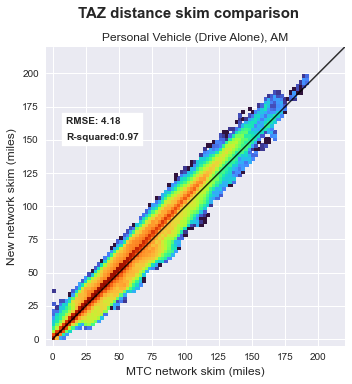

In [9]:
plt.style.use('seaborn')
plt.hist2d(skim_diff[var], skim_diff[f'{var}_new'], bins=80, norm=colors.LogNorm(), cmap ="turbo")
plt.gca().set_aspect("equal")
plt.grid(b=None, which='major', axis='both')
plt.plot(np.linspace(0, 220, 300), np.linspace(0, 220, 300), color='black', lw=1.5, alpha=0.8)
plt.text(10, 150, f'RMSE: {round(rmse,2)}\nR-squared:{round(r2,2)}', backgroundcolor='w', fontsize=10, weight='bold', linespacing=2)
plt.suptitle('TAZ distance skim comparison', fontsize=15, weight='bold')
plt.title('Personal Vehicle (Drive Alone), AM', fontsize=12)
plt.xlabel('MTC network skim (miles)', fontsize=12, labelpad=5)
plt.ylabel('New network skim (miles)', fontsize=12, labelpad=5)
plt.xlim((-5, 220))
plt.ylim((-5, 220))
plt.show()

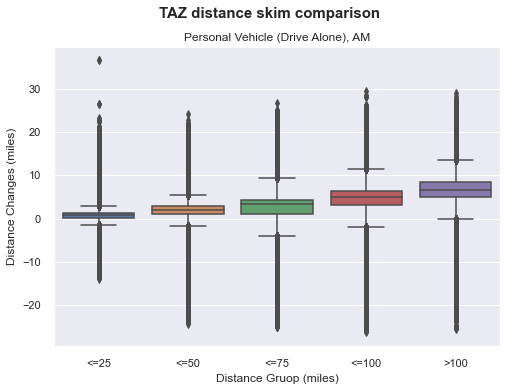

In [10]:
sns.set_theme()
sns.boxplot(data=skim_diff, x='group', y='diff', order=choices)
plt.suptitle('TAZ distance skim comparison', fontsize=15, weight='bold')
plt.title('Personal Vehicle (Drive Alone), AM', fontsize=12)
plt.xlabel('Distance Gruop (miles)', fontsize=12, labelpad=5)
plt.ylabel('Distance Changes (miles)', fontsize=12, labelpad=5)
plt.show()